# (d) Few-short self-remainder (0.25% stored samples)
### Training on a depleted set of digits + set of letters after training on a set of digits

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

#import import_ipynb
#from MozafariMNIST2018_class import MozafariMNIST2018

## Model

In [2]:
class MozafariMNIST2018(nn.Module):
    
    def __init__(self):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [3]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [4]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
# train of 3-rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set, steps=None, percent=20, it_continues=False):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    previous_epochs - if before model had training in current period
    it_continues - is it continue of 3-rd layer training or not (False or True)
    percent - percent of moving weights (calculated from the number of high range weights)
    '''

    adaptive_min=0 

    if not it_continues:

        previous_epochs = 0
        counter = 0

        apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
        anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
        app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
        anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp
        
        best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

    else:
      
        if len(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch']) == 1:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].item())
        else:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch']) == 1:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].item())
        else:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch']) == 1:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].item())
        else:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].tolist()[-1])
        
        max_index = int(parametr_set.index.max())
        counter = (max_index + 1)

        param_best_train = parametr_set['train'].iloc[best_train_index]
        param_best_test = parametr_set['test'].iloc[optim_index]
        param_best_test_previous = parametr_set['test_previous'].iloc[best_test_previous_index]

        apr_adapt = parametr_set['apr_adapt'].iloc[optim_index]
        anr_adapt = parametr_set['anr_adapt'].iloc[optim_index]
        app_adapt = parametr_set['app_adapt'].iloc[optim_index]
        anp_adapt = parametr_set['anp_adapt'].iloc[optim_index]
        
        for i in range(len(mozafari.stdp3.learning_rate)):
            mozafari.stdp3.learning_rate[i][0].fill_(parametr_set['stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.stdp3.learning_rate[i][1].fill_(parametr_set['stdp3.learning_rate[1]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[0]'].iloc[optim_index])
            mozafari.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[1]'].iloc[optim_index])

        best_train = np.array([param_best_train,1-param_best_train,0.0,best_train_index]) # correct, wrong, silence, epoch
        best_test = np.array([param_best_test,1-param_best_test,0.0,optim_index]) # correct, wrong, silence, epoch
        best_test_previous = np.array([param_best_test_previous,1-param_best_test_previous,0.0,best_test_previous_index]) # correct, wrong, silence, epoch
    
    # list of 3-rd layer weights

    dim_0, dim_1, dim_2, dim_3 = tuple(mozafari.conv3.weight.size())
    total_size = dim_0 * dim_1 * dim_2 * dim_3
  
    # indexes of weights
    indexes_i = []    
    indexes_j = []        
    indexes_k = []        
    indexes_m = []    
    
    # values of weights
    item_values = []  
    
    for i in range(dim_0):
        for j in range(dim_1):
            for k in range(dim_2):
                for m in range(dim_3):
                    indexes_i.append(i)
                    indexes_j.append(j)
                    indexes_k.append(k)
                    indexes_m.append(m)
                    item_values.append(mozafari.conv3.weight[i][j][k][m].item())

    indexes_dim_0 = pd.Series(indexes_i, name='dim_0') 
    indexes_dim_1 = pd.Series(indexes_j, name='dim_1')
    indexes_dim_2 = pd.Series(indexes_k, name='dim_2')
    indexes_dim_3 = pd.Series(indexes_m, name='dim_3')
    item_values = pd.Series(item_values, name='value_0')
            
    conv3_data = pd.concat([item_values, indexes_dim_0, indexes_dim_1, indexes_dim_2, indexes_dim_3], axis=1)
    
    high_percent = 85 #percent of high range weights
    percentile_value = np.percentile(item_values, high_percent)
    
    conv3_data['low_range_0'] = 0
    conv3_data.loc[conv3_data['value_0'] < percentile_value,'low_range_0'] = 1
    
    try:
        high_range_counter = conv3_data['low_range_0'].value_counts()[0] 
    except:
        high_range_counter = 1
 
    moving_quantity = int((percent/100)*high_range_counter) #quantity of moving items in each epoch
    
    if steps is None:
        steps = int(total_size*high_percent/(100*moving_quantity))   #steps of weights moving 
    print(f'Weight moving will be during {steps} epochs')
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
                
            if epoch < steps: 
                
                print(f'Values of high range weights in epoch#{epoch} [{percentile_value :.3f}:0.800] (top {100-high_percent}%)')
                low_range_indexes = list(conv3_data.index[conv3_data['low_range_'+str(epoch)] == 1])
                moving_items = random.sample(low_range_indexes, np.minimum(moving_quantity, len(low_range_indexes)))
                moving_indexes = conv3_data.loc[conv3_data.index.isin(moving_items)]

                print(f'Quantity of moving points in epoch#{epoch + previous_epochs} = {len(moving_indexes.index)} items' 
                      f' ({len(moving_indexes.index)/(total_size-high_range_counter)*100 :.1f}% of moving points)')

                for q in range(len(moving_indexes.index)):
                    mozafari.conv3.weight \
                    [moving_indexes['dim_0'].iloc[q]][moving_indexes['dim_1'].iloc[q]][moving_indexes['dim_2'].iloc[q]][moving_indexes['dim_3'].iloc[q]]. \
                    fill_(np.random.normal(loc=0.8, scale=0.05))  
              
            perf_train_batch = train_rl(model, data, targets)
    
            if epoch < steps:  
            
                # new values of weights (after learning)
                item_values = []       
                for i in range(dim_0):
                    for j in range(dim_1):
                        for k in range(dim_2):
                            for m in range(dim_3):
                                item_values.append(mozafari.conv3.weight[i][j][k][m].item())
            
                item_values = pd.Series(item_values, name='value_'+str(epoch+1))
                percentile_value = np.percentile(item_values, high_percent) #new cutting off high range weights
                conv3_data = pd.concat([conv3_data, item_values], axis=1)
                
                conv3_data['low_range_'+str(epoch+1)] = 0
                conv3_data.loc[conv3_data['value_'+str(epoch+1)] < percentile_value,'low_range_'+str(epoch+1)] = 1
       
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = mozafari.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = mozafari.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = mozafari.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = mozafari.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")
        #print("   Best Train:", best_train)

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")
            #print("    Best Test:", best_test)

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                #print("    Best Test Previous:", best_test_previous)
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set, counter, (previous_epochs+epochs), apr, anr, app, anp, conv3_data

In [6]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 10000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [7]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [9]:
# prediction

def pred(network, data, target):
    prediction_d = []
    target_ = [] 
    network.eval()
    
    for i in range(len(data)):
        
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        pred_d = network(data_in, 3)
            
        prediction_d.append(pred_d)
        target_.append(target_in)
        
    return prediction_d, target_

## Sets

### Depleted digit sets
24000 train and 4000 test images

In [10]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
# the set contains only 0.25% of the original images of 10 digits (the rest of the images are duplicates of the original)

path = f'./data/MNIST_depleted_sets/'

for i in classes:
    globals()[f'train_depleted_digit_{i}_images'] = \
        torch.load(f'{path}depleted_train_{i}_images.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_depleted_digit_{i}_images'] = \
        torch.load(f'{path}depleted_test_{i}_images.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'train_depleted_digit_{i}_lables'] = \
        torch.load(f'{path}depleted_train_{i}_lables.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_depleted_digit_{i}_lables'] = \
        torch.load(f'{path}depleted_test_{i}_lables.pt', map_location=torch.device('cpu'))[0:400]
    
train_depleted_digit_images = train_depleted_digit_0_images
train_depleted_digit_lables = train_depleted_digit_0_lables

test_depleted_digit_images = test_depleted_digit_0_images
test_depleted_digit_lables = test_depleted_digit_0_lables
    
for i in range(1, 10):    
    train_depleted_digit_images = torch.cat((train_depleted_digit_images, \
                                                        globals()[f'train_depleted_digit_{i}_images']), 0)
    train_depleted_digit_lables = torch.cat((train_depleted_digit_lables, \
                                                            globals()[f'train_depleted_digit_{i}_lables']), 0)
    
    test_depleted_digit_images = torch.cat((test_depleted_digit_images, \
                                                        globals()[f'test_depleted_digit_{i}_images']), 0)
    test_depleted_digit_lables = torch.cat((test_depleted_digit_lables, \
                                                            globals()[f'test_depleted_digit_{i}_lables']), 0)

In [12]:
# Element permutation

train_order = torch.randperm(train_depleted_digit_lables.shape[0])
test_order = torch.randperm(test_depleted_digit_lables.shape[0])

train_depleted_digit_lables = train_depleted_digit_lables[train_order].view(train_depleted_digit_lables.size())
train_depleted_digit_images = train_depleted_digit_images[train_order].view(train_depleted_digit_images.size())

test_depleted_digit_lables = test_depleted_digit_lables[test_order].view(test_depleted_digit_lables.size())
test_depleted_digit_images = test_depleted_digit_images[test_order].view(test_depleted_digit_images.size())

# Loaders

train_depleted_digit_set = CustomTensorDataset(tensors=(train_depleted_digit_images, train_depleted_digit_lables), transform=s1c1_PIL)
test_depleted_digit_set = CustomTensorDataset(tensors=(test_depleted_digit_images, test_depleted_digit_lables), transform=s1c1_PIL)

train_depleted_digit_loader = DataLoader(train_depleted_digit_set, batch_size=len(train_depleted_digit_set))
test_depleted_digit_loader = DataLoader(test_depleted_digit_set, batch_size=len(test_depleted_digit_set))

### Set of 10 MNIST digits
60000 train images + 10000 test images

In [13]:
# initial dataset

data_root = "data"

MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = s1c1))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = s1c1))

train_MNIST_loader = DataLoader(MNIST_train, batch_size=len(MNIST_train), shuffle=False)
test_MNIST_loader = DataLoader(MNIST_test, batch_size=len(MNIST_test), shuffle=False)

### Set of 10 capital letters
24000 train images + 4000 test images

In [14]:
# set of 10 capital letters from EMNIST

path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

# Loaders

train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

### Combined set of depleted digit set + capital letter set

48000 train + 8000 test images

In [15]:
# combined set

train_combi_labels = torch.cat((train_depleted_digit_lables, train_letter_labels), 0)
train_combi_images = torch.cat((train_depleted_digit_images, train_letters), 0)
test_combi_labels = torch.cat((test_depleted_digit_lables, test_letter_labels), 0)
test_combi_images = torch.cat((test_depleted_digit_images, test_letters), 0)

# Element permutation

train_order_c = torch.randperm(train_combi_labels.shape[0])
test_order_c = torch.randperm(test_combi_labels.shape[0])

train_combi_labels = train_combi_labels[train_order_c].view(train_combi_labels.size())
train_combi_images = train_combi_images[train_order_c].view(train_combi_images.size())

test_combi_labels = test_combi_labels[test_order_c].view(test_combi_labels.size())
test_combi_images = test_combi_images[test_order_c].view(test_combi_images.size())

# Loaders

train_combi_set = CustomTensorDataset(tensors=(train_combi_images, \
                                                train_combi_labels), transform=s1c1_PIL)
test_combi_set = CustomTensorDataset(tensors=(test_combi_images, \
                                                test_combi_labels), transform=s1c1_PIL)

train_combi_loader = DataLoader(train_combi_set, batch_size=len(train_combi_set))
test_combi_loader = DataLoader(test_combi_set, batch_size=len(test_combi_set))

## Model activation

In [16]:
mozafari = MozafariMNIST2018()

In [17]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [18]:
if use_cuda:
    mozafari.cuda()   

mozafari.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Continuous learning  
Training on combi set of digits (depleted set, 0.25% stored samples) + letters

### Saving all values of parameters before training on digits

In [19]:
learning_rate_from_scratch = {'stdp1': [mozafari.stdp1.learning_rate[0][0].item(), 
                                        mozafari.stdp1.learning_rate[0][1].item()],
                              'stdp2': [mozafari.stdp2.learning_rate[0][0].item(), 
                                        mozafari.stdp2.learning_rate[0][1].item()],
                              'stdp3': [mozafari.stdp3.learning_rate[0][0].item(), 
                                        mozafari.stdp3.learning_rate[0][1].item()],
                              'anti_stdp3': [mozafari.anti_stdp3.learning_rate[0][0].item(), 
                                             mozafari.anti_stdp3.learning_rate[0][1].item()]
                             }

### Installation of SNN trained on 24,000 images of digits

In [20]:
# file "saved_24000_digits.net" is the result of the file "Initial_learning_of_SNN_on_digits.ipynb"
mozafari.load_state_dict(torch.load("saved_24000_digits.net"))

<All keys matched successfully>

### Training the first layer

In [21]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_combi_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1

Training the first layer
Epoch 0
0 images
10000 images
20000 images
30000 images
40000 images
Iteration 0
Done!
Epoch 1
50000 images
60000 images
70000 images
80000 images
90000 images
Iteration 0
Done!


### Training the second layer

In [22]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_combi_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1

Training the second layer
Epoch 0
100000 images
110000 images
120000 images
130000 images
140000 images
Iteration 0
Done!
Epoch 1
150000 images
160000 images
170000 images
180000 images
190000 images
Iteration 0
Done!
Epoch 2
200000 images
210000 images
220000 images
230000 images
Iteration 0
Done!
Epoch 3
240000 images
250000 images
260000 images
270000 images
280000 images
Iteration 0
Done!


### Training the third layer

In [23]:
# Moving learning_rates 

for i in range(len(mozafari.stdp3.learning_rate)):
                    mozafari.stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['stdp3'][0])
                    mozafari.stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['stdp3'][1])
                    mozafari.anti_stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['anti_stdp3'][0])
                    mozafari.anti_stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['anti_stdp3'][1])

In [24]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

In [25]:
# train the 3-rd layer

first_test = third_layer(file_name_net="saved_few_short_leaning_total_0.net",
                        file_name_csv='parameter_set_few_short_leaning_0.csv',
                        adaptive_int=0.5, previous_epochs=0, epochs=100, 
                        train_loader=train_combi_loader, 
                        test_loader=test_letter_loader, 
                        test_previous_loader=test_MNIST_loader,
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set, steps=0, percent=0, it_continues=False)

parametr_set = first_test[0] 
counter = first_test[1] 
previous_epochs = first_test[2]
apr = first_test[3] 
anr = first_test[4] 
app = first_test[5] 
anp = first_test[6]
conv3_data_train = first_test[7]

Weight moving will be during 0 epochs
--------------------------------------------------
Epoch #:  0
290000 images
300000 images
310000 images
320000 images
330000 images
Current Train: 70.46%
Current Test: 50.18%
0 images
Current Test Previous: 59.71%
Operational time of epoch #0: 4 min 12 sec
--------------------------------------------------
Epoch #:  1
340000 images
350000 images
360000 images
370000 images
380000 images
Current Train: 75.98%
390000 images
Current Test: 54.17%
Current Test Previous: 65.57%
Operational time of epoch #1: 3 min 54 sec
--------------------------------------------------
Epoch #:  2
400000 images
410000 images
420000 images
430000 images
Current Train: 77.21%
440000 images
Current Test: 55.75%
Current Test Previous: 71.66%
Operational time of epoch #2: 3 min 45 sec
--------------------------------------------------
Epoch #:  3
450000 images
460000 images
470000 images
480000 images
490000 images
Current Train: 77.96%
Current Test: 56.97%
Current Test Pre

1960000 images
1970000 images
1980000 images
1990000 images
Current Train: 84.65%
2000000 images
Current Test: 68.35%
Current Test Previous: 76.35%
Operational time of epoch #32: 3 min 49 sec
--------------------------------------------------
Epoch #:  33
2010000 images
2020000 images
2030000 images
2040000 images
2050000 images
Current Train: 84.72%
Current Test: 68.15%
Current Test Previous: 76.55%
Operational time of epoch #33: 3 min 50 sec
--------------------------------------------------
Epoch #:  34
2060000 images
2070000 images
2080000 images
2090000 images
2100000 images
Current Train: 84.78%
Current Test: 68.40%
Current Test Previous: 76.37%
Operational time of epoch #34: 3 min 50 sec
--------------------------------------------------
Epoch #:  35
2110000 images
2120000 images
2130000 images
2140000 images
2150000 images
Current Train: 84.91%
Current Test: 68.33%
Current Test Previous: 76.49%
Operational time of epoch #35: 3 min 50 sec
----------------------------------------

3620000 images
3630000 images
3640000 images
3650000 images
3660000 images
Current Train: 87.16%
Current Test: 71.88%
Current Test Previous: 74.97%
Operational time of epoch #64: 3 min 44 sec
--------------------------------------------------
Epoch #:  65
3670000 images
3680000 images
3690000 images
3700000 images
3710000 images
Current Train: 87.25%
Current Test: 71.75%
Current Test Previous: 74.96%
Operational time of epoch #65: 3 min 44 sec
--------------------------------------------------
Epoch #:  66
3720000 images
3730000 images
3740000 images
3750000 images
3760000 images
Current Train: 87.28%
3770000 images
Current Test: 71.97%
Current Test Previous: 74.98%
Operational time of epoch #66: 3 min 44 sec
--------------------------------------------------
Epoch #:  67
3780000 images
3790000 images
3800000 images
3810000 images
Current Train: 87.25%
3820000 images
Current Test: 72.08%
Current Test Previous: 74.91%
Operational time of epoch #67: 3 min 44 sec
-------------------------

5290000 images
5300000 images
5310000 images
5320000 images
Current Train: 88.51%
5330000 images
Current Test: 74.35%
Current Test Previous: 74.90%
Operational time of epoch #96: 3 min 45 sec
--------------------------------------------------
Epoch #:  97
5340000 images
5350000 images
5360000 images
5370000 images
Current Train: 88.55%
5380000 images
Current Test: 74.33%
Current Test Previous: 74.91%
Operational time of epoch #97: 3 min 48 sec
--------------------------------------------------
Epoch #:  98
5390000 images
5400000 images
5410000 images
5420000 images
5430000 images
Current Train: 88.57%
Current Test: 74.35%
Current Test Previous: 74.83%
Operational time of epoch #98: 3 min 46 sec
--------------------------------------------------
Epoch #:  99
5440000 images
5450000 images
5460000 images
5470000 images
5480000 images
Current Train: 88.57%
Current Test: 74.45%
Current Test Previous: 74.90%
Operational time of epoch #99: 3 min 43 sec
==================== SUMMARY ===========

## Results chart

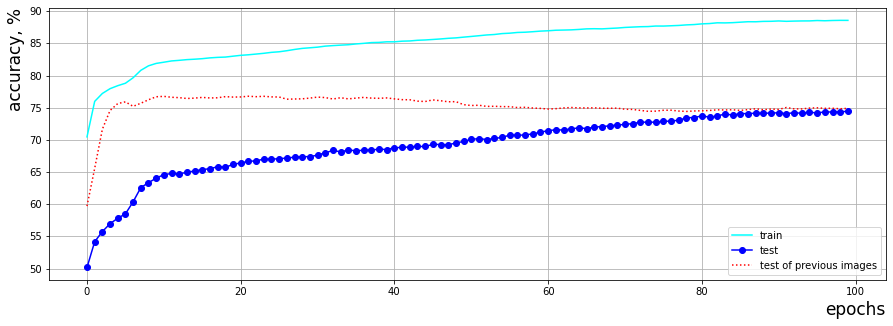

In [26]:
curve_graph(parametr_set)